## Predikcia parametrov pre detached krivky
### Predikovane parametre: inclination, mass ratio, primary surface potential, secondary surface potential, temperature ratio
Model je trenovany na normovanych krivkach so sumom

In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.utils import np_utils, plot_model
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

np.random.seed(1234)
pd.set_option('display.max_rows', None)

In [2]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

In [3]:
data = pd.read_pickle("detached_all_parameters.pkl").reset_index()
data_sample = data.sample(n=400000)

In [4]:
X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

y = np.array(data_sample[[
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2"]])

In [5]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
# Adding noise to train data
X_train_n = []
y_train_n = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train_n.append(curve[0])
        y_train_n.append(y_train1[i])
X_train_n = np.array(X_train_n)
y_train_n=np.array(y_train_n)

In [7]:
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(data_sample),
    "\nNumber of train data without noise: ", len(X_train1),
    "\nNumber of train data with noise: ", len(X_train_n),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1300000 
Number of records in sample:  400000 
Number of train data without noise:  320000 
Number of train data with noise:  960000 
Number of test data without noise:  80000


In [9]:
y_inc = np.array([arr[0] for arr in y_train_n])
y_mass = np.array([arr[1] for arr in y_train_n])
y_prim_potent = np.array([arr[2] for arr in y_train_n])
y_sec_potent = np.array([arr[3] for arr in y_train_n])
y_temp_ratio = np.array([arr[4] for arr in y_train_n])

In [10]:
y_inc = y_inc.reshape(-1,1)
y_mass = y_mass.reshape(-1,1)
y_prim_potent = y_prim_potent.reshape(-1,1)
y_sec_potent = y_sec_potent.reshape(-1,1)
y_temp_ratio = y_temp_ratio.reshape(-1,1)

In [11]:
# MinMax Scaler - each attribute is scaled separately
scaler_inc = MinMaxScaler()
scaler_q = MinMaxScaler()
scaler_pp = MinMaxScaler()
scaler_sp = MinMaxScaler()
scaler_tr = MinMaxScaler()

y_inc_scaled = scaler_inc.fit_transform(y_inc)
y_q_scaled = scaler_q.fit_transform(y_mass)
y_pp_scaled = scaler_pp.fit_transform(y_prim_potent)
y_sp_scaled = scaler_sp.fit_transform(y_sec_potent)
y_tr_scaled = scaler_tr.fit_transform(y_temp_ratio)

In [13]:
y_inc_scaled = np.array(y_inc_scaled)
y_q_scaled = np.array(y_q_scaled)
y_pp_scaled = np.array(y_pp_scaled)
y_sp_scaled = np.array(y_sp_scaled)
y_tr_scaled = np.array(y_tr_scaled)

/tmp/ipykernel_122/2954303928.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b="on")


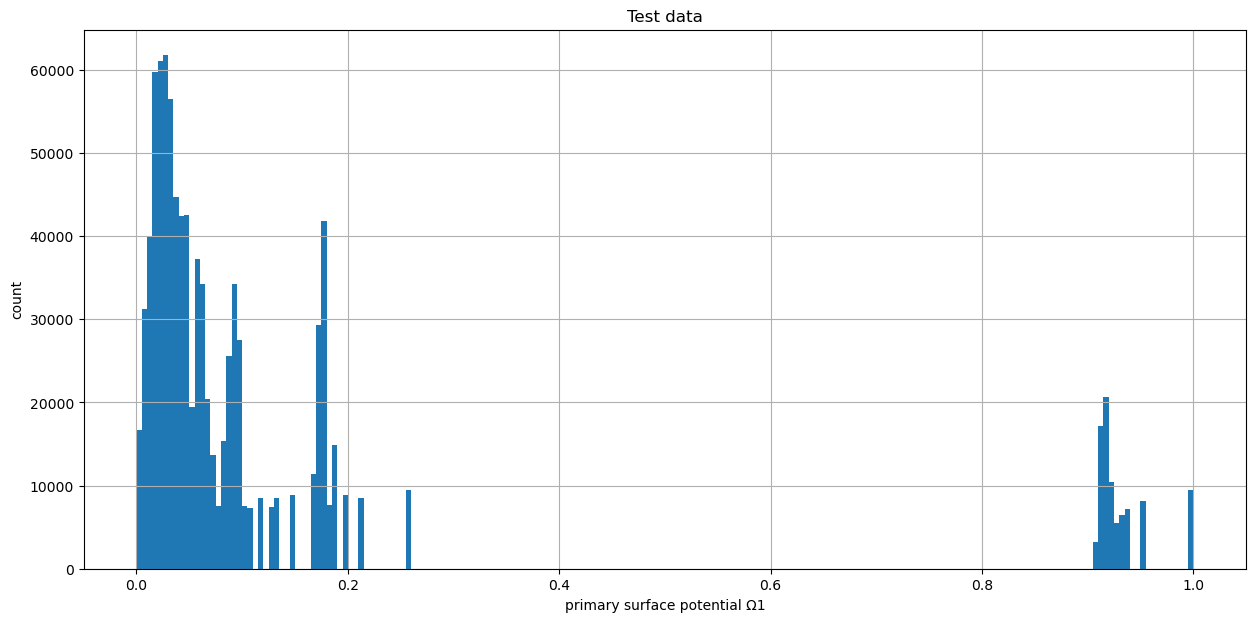

In [18]:
# Vykreslenie distribucie
plt.figure(figsize=(15,7))
plt.hist(y_pp_scaled, bins=200)
plt.title("Test data")
plt.xlabel("primary surface potential Ω1")
plt.ylabel("count")
plt.grid(b="on")
plt.show()

In [21]:
inputs_y = Input(shape=(400, 1))

a = Conv1D(128, kernel_size = 3, padding = "valid")(inputs_y)
a = LSTM(64, return_sequences=True)(a)
a = Flatten()(a)
a = Dense(64, activation='relu')(a)
a = Model(inputs=inputs_y, outputs=a)

b = Conv1D(128, kernel_size = 3, padding = "valid")(inputs_y)
b = MaxPooling1D(2)(b)
b = Conv1D(128, kernel_size = 3, padding = "valid")(b)
b = LSTM(64, return_sequences=True)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
b = Model(inputs=inputs_y, outputs=b)

c = Conv1D(128, kernel_size = 3, padding = "valid")(inputs_y)
c = MaxPooling1D(2)(c)
c = Conv1D(128, kernel_size = 3, padding = "valid")(c)
c = LSTM(64, return_sequences=True)(c)
c = LSTM(64, return_sequences=True)(c)
c = Flatten()(c)
c = Dense(64, activation='relu')(c)
c = Model(inputs=inputs_y, outputs=c)

d = Conv1D(128, kernel_size = 3, padding = "valid")(inputs_y)
d = MaxPooling1D(2)(d)
d = Conv1D(128, kernel_size = 3, padding = "valid")(d)
d = LSTM(64, return_sequences=True)(d)
d = LSTM(64, return_sequences=True)(d)
d = Flatten()(d)
d = Dense(64, activation='relu')(d)
d = Model(inputs=inputs_y, outputs=d)

e = Conv1D(128, kernel_size = 3, padding = "valid")(inputs_y)
e = MaxPooling1D(2)(e)
e = Conv1D(128, kernel_size = 3, padding = "valid")(e)
e = LSTM(64, return_sequences=True)(e)
e = LSTM(64, return_sequences=True)(e)
e = Flatten()(e)
e = Dense(64, activation='relu')(e)
e = Model(inputs=inputs_y, outputs=e)

x = concatenate([a.output, b.output, c.output, d.output, e.output])
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

output = Dense(5, activation='linear')(x)

detached_multiNN_norm_model = Model(inputs=inputs_y, outputs=output)
detached_multiNN_norm_model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(detached_multiNN_norm_model.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 398, 128)     512         ['input_2[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 398, 128)     512         ['input_2[0][0]']                
                                                                                                  
 conv1d_14 (Conv1D)             (None, 398, 128)     512         ['input_2[0][0]']                
                                                                                           

In [22]:
saved_model = "models/det_multiNN_norm_model.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
csv_logger = CSVLogger('det_multiNN_norm_model.log', separator=',', append = True)
callbacks_list = [checkpoint, early, csv_logger]

In [25]:
history_multiNN_norm = detached_multiNN_norm_model.fit(
    x=X_train_n,
    y=[y_inc_scaled, y_q_scaled, y_pp_scaled, y_sp_scaled, y_tr_scaled],
    validation_split = 0.1,
    epochs = 15,
    verbose = 1,
    callbacks = callbacks_list,
    batch_size = 64)

Epoch 1/15


2023-01-14 16:52:30.756119: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


13500/13500 [==============================] - ETA: 0s - loss: 0.0104 - mae: 0.0713 - mape: 165727.7812
Epoch 1: val_mae improved from inf to 0.06958, saving model to models/det_multiNN_norm_model.hdf5
13500/13500 [==============================] - 1410s 104ms/step - loss: 0.0104 - mae: 0.0713 - mape: 165727.7812 - val_loss: 0.0080 - val_mae: 0.0696 - val_mape: 116346.7734
Epoch 2/15
13500/13500 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0512 - mape: 146182.1094
Epoch 2: val_mae improved from 0.06958 to 0.06256, saving model to models/det_multiNN_norm_model.hdf5
13500/13500 [==============================] - 1379s 102ms/step - loss: 0.0058 - mae: 0.0512 - mape: 146182.1094 - val_loss: 0.0068 - val_mae: 0.0626 - val_mape: 115670.8281
Epoch 3/15
13500/13500 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0467 - mape: 143723.0781
Epoch 3: val_mae did not improve from 0.06256
13500/13500 [==============================] - 1380s 102ms/step - loss: 

## Vyhodnotenie modelu - loss, MAE

In [26]:
multi_model = load_model("models/det_multiNN_norm_model.hdf5")

In [28]:
scores = multi_model.evaluate(X_test, y_test) 
print('Multi NN model -- Loss: {:.4f}, MAE: {:.4f}'.format(scores[0], scores[1]))

2500/2500 [==============================] - 106s 41ms/step - loss: 677.5099 - mae: 7.4669 - mape: 74.3023
Multi NN model -- Loss: 677.5099, MAE: 7.4669


In [29]:
# Adding noise to  test data
X_test_n = []
y_test_n = []
for i in range(len(X_test)):
    for j in range(3):
        curve = stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_n.append(y_test[i])
        j += 1
X_test_n = np.array(X_test_n)
y_test_n = np.array(y_test_n)

In [30]:
scores_n = multi_model.evaluate(X_test_n, y_test_n) 
print('Multi NN model - data with noise -- Loss: {:.4f}, MAE: {:.4f}'.format(scores_n[0], scores_n[1]))

7500/7500 [==============================] - 313s 42ms/step - loss: 677.5145 - mae: 7.4660 - mape: 74.2880
Multi NN model - data with noise -- Loss: 677.5145, MAE: 7.4660


## Predikcie - data bez sumu

In [48]:
pred_multi = multi_model.predict(X_test)
pred_multi[0]

2500/2500 [==============================] - 101s 40ms/step


array([0.31985906, 0.31986335, 0.31986684, 0.3198728 , 0.31986997],
      dtype=float32)

In [49]:
pred_inc = np.array([arr[0] for arr in pred_multi])
pred_mass = np.array([arr[1] for arr in pred_multi])
pred_prim_potent = np.array([arr[2] for arr in pred_multi])
pred_sec_potent = np.array([arr[3] for arr in pred_multi])
pred_temp_ratio = np.array([arr[4] for arr in pred_multi])

In [50]:
pred_inc[0:10]

array([0.31985906, 0.78190315, 0.746999  , 0.66448075, 0.8521988 ,
       0.82561046, 0.7856216 , 0.66779435, 0.90486383, 0.84347826],
      dtype=float32)

In [51]:
pred_inc = pred_inc.reshape(-1,1)
pred_mass = pred_mass.reshape(-1,1)
pred_prim_potent = pred_prim_potent.reshape(-1,1)
pred_sec_potent = pred_sec_potent.reshape(-1,1)
pred_temp_ratio = pred_temp_ratio.reshape(-1,1)

In [52]:
pred_inc_denorm = scaler_inc.inverse_transform(pred_inc)
pred_q_denorm = scaler_q.inverse_transform(pred_mass)
pred_pp_denorm = scaler_pp.inverse_transform(pred_prim_potent)
pred_sp_denorm = scaler_sp.inverse_transform(pred_sec_potent)
pred_tr_denorm = scaler_tr.inverse_transform(pred_temp_ratio)

In [62]:
pred_inc_denorm = pred_inc_denorm.flatten()
pred_q_denorm = pred_q_denorm.flatten()
pred_pp_denorm = pred_pp_denorm.flatten()
pred_sp_denorm = pred_sp_denorm.flatten()
pred_tr_denorm = pred_tr_denorm.flatten()

In [64]:
predictions_df = pd.DataFrame()
predictions_df['pred_inc_denorm']=pd.Series(pred_inc_denorm)
predictions_df['pred_q_denorm']=pd.Series(pred_q_denorm)
predictions_df['pred_pp_denorm']=pd.Series(pred_pp_denorm)
predictions_df['pred_sp_denorm']=pd.Series(pred_sp_denorm)
predictions_df['pred_tr_denorm']=pd.Series(pred_tr_denorm)
predictions_df.head()

,pred_inc_denorm,pred_q_denorm,pred_pp_denorm,pred_sp_denorm,pred_tr_denorm
0,1.004191,3.266647,36.559208,320.140869,4.278667
1,1.389106,7.840817,86.449417,779.603943,9.014439
2,1.360029,7.495257,82.680305,744.890198,8.656649
3,1.291285,6.678303,73.769562,662.821899,7.810781
4,1.447667,8.536765,94.040306,849.516174,9.735017


In [66]:
pred_mean = predictions_df.mean(axis=0)
pred_mean

pred_inc_denorm      1.375205
pred_q_denorm        7.675644
pred_pp_denorm      84.647873
pred_sp_denorm     763.017517
pred_tr_denorm       8.843466
dtype: float32

In [67]:
test_df = pd.DataFrame(y_test,
                        columns = [
                            "inclination",
                            "mass_ratio",
                            "primary__surface_potential",
                            "secondary__surface_potential",
                            "t1_t2"
                            ])
test_df = test_df.mean(axis=0)
test_df

inclination                      1.375489
mass_ratio                       1.762092
primary__surface_potential      18.131032
secondary__surface_potential    17.008164
t1_t2                            2.649509
dtype: float64

In [68]:
eval_pred = pd.DataFrame({'attribute': test_df.index,
            'avg_true': test_df.values,
            'avg_pred': pred_mean.values,
            'MAE': abs(test_df.values - pred_mean.values)})
eval_pred

,attribute,avg_true,avg_pred,MAE
0,inclination,1.375489,1.375205,0.000285
1,mass_ratio,1.762092,7.675644,5.913552
2,primary__surface_potential,18.131032,84.647873,66.516841
3,secondary__surface_potential,17.008164,763.017517,746.009353
4,t1_t2,2.649509,8.843466,6.193957


## Predikcie - data so sumom

In [69]:
pred_multi_n= multi_model.predict(X_test_n)
pred_multi_n[0]

7500/7500 [==============================] - 308s 41ms/step


array([0.31674588, 0.31675026, 0.3167538 , 0.3167599 , 0.316757  ],
      dtype=float32)

In [71]:
pred_inc_n = np.array([arr[0] for arr in pred_multi_n])
pred_mass_n = np.array([arr[1] for arr in pred_multi_n])
pred_prim_potent_n = np.array([arr[2] for arr in pred_multi_n])
pred_sec_potent_n = np.array([arr[3] for arr in pred_multi_n])
pred_temp_ratio_n = np.array([arr[4] for arr in pred_multi_n])

In [72]:
pred_inc_n = pred_inc_n.reshape(-1,1)
pred_mass_n = pred_mass_n.reshape(-1,1)
pred_prim_potent_n = pred_prim_potent_n.reshape(-1,1)
pred_sec_potent_n = pred_sec_potent_n.reshape(-1,1)
pred_temp_ratio_n = pred_temp_ratio_n.reshape(-1,1)

In [73]:
pred_inc_denorm_n = scaler_inc.inverse_transform(pred_inc_n).flatten()
pred_q_denorm_n = scaler_q.inverse_transform(pred_mass_n).flatten()
pred_pp_denorm_n = scaler_pp.inverse_transform(pred_prim_potent_n).flatten()
pred_sp_denorm_n = scaler_sp.inverse_transform(pred_sec_potent_n).flatten()
pred_tr_denorm_n = scaler_tr.inverse_transform(pred_temp_ratio_n).flatten()

In [75]:
predictions_n_df = pd.DataFrame()
predictions_n_df['pred_inc_denorm_n']=pd.Series(pred_inc_denorm_n)
predictions_n_df['pred_q_denorm_n']=pd.Series(pred_q_denorm_n)
predictions_n_df['pred_pp_denorm_n']=pd.Series(pred_pp_denorm_n)
predictions_n_df['pred_sp_denorm_n']=pd.Series(pred_sp_denorm_n)
predictions_n_df['pred_tr_denorm_n']=pd.Series(pred_tr_denorm_n)
predictions_n_df.head()

,pred_inc_denorm_n,pred_q_denorm_n,pred_pp_denorm_n,pred_sp_denorm_n,pred_tr_denorm_n
0,1.001598,3.235828,36.223064,317.045227,4.246759
1,1.005403,3.281046,36.716248,321.587067,4.293573
2,1.004006,3.264449,36.535233,319.920044,4.276391
3,1.389086,7.840571,86.446739,779.579224,9.014184
4,1.388277,7.830962,86.341927,778.613770,9.004234


In [76]:
pred_mean_n = predictions_n_df.mean(axis=0)
pred_mean_n

pred_inc_denorm_n      1.376187
pred_q_denorm_n        7.687326
pred_pp_denorm_n      84.775391
pred_sp_denorm_n     764.191711
pred_tr_denorm_n       8.855566
dtype: float32

In [77]:
test_df_n = pd.DataFrame(y_test_n,
                        columns = [
                            "inclination",
                            "mass_ratio",
                            "primary__surface_potential",
                            "secondary__surface_potential",
                            "t1_t2"
                            ])
test_df_n = test_df_n.mean(axis=0)
test_df_n

inclination                      1.375489
mass_ratio                       1.762092
primary__surface_potential      18.131032
secondary__surface_potential    17.008164
t1_t2                            2.649509
dtype: float64

In [78]:
eval_pred_n = pd.DataFrame({'attribute': test_df_n.index,
            'avg_true': test_df_n.values,
            'avg_pred': pred_mean_n.values,
            'MAE': abs(test_df_n.values - pred_mean_n.values)})
eval_pred_n

,attribute,avg_true,avg_pred,MAE
0,inclination,1.375489,1.376187,0.000698
1,mass_ratio,1.762092,7.687326,5.925234
2,primary__surface_potential,18.131032,84.775391,66.644359
3,secondary__surface_potential,17.008164,764.191711,747.183548
4,t1_t2,2.649509,8.855566,6.206057
